imports

In [ ]:
from __future__ import print_function, division
from builtins import range

import os
import sys,re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, GlobalMaxPool1D, SpatialDropout1D, Conv1D
from tensorflow.keras.layers import LSTM, MaxPooling1D, Embedding, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
# import tensorflow.keras.backend as K
from sklearn.metrics import roc_auc_score

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


some configuration

In [ ]:
MAX_SEQUENCE_LENGTH = 232
MAX_VOCAB_SIZE = 30000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 3

load in pre-trained word vectors

In [ ]:
word2vec = {}
with open(os.path.join('/content/gdrive/My Drive/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec


In [ ]:
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [ ]:
!python -m spacy download en_core_web_sm
import spacy

nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


prepare text samples and their labels <br/>
**this takes some time bcz it is RAM efficient**

In [ ]:
import time
start_time = time.time()

words = np.empty(0,dtype='object')
targets = np.empty(0,dtype='int')
labels = { "ArtOrDet":2,"Nn":3,"Vt":4,"Prep":5,"Vform":6,"Wform":7,"SVA":8 }
i=0
f=open('/content/gdrive/My Drive/conll14st-preprocessed.m2')
line = f.readline()
while line:
    line = line.strip()
    if line:
        if re.search("^S",line):
            line = line[2:]
            minfull=""
            lenline = len(line.split())
            a=np.ones(lenline,dtype='int')
            b=np.empty(0,dtype='object')
            targets=np.concatenate([targets,a])
            doc = nlp(line)
            for token in doc:
                minfull=minfull+token.pos_+" "
            for word in line.split():
                b=np.concatenate([b,[word+" "+minfull]])
                #words=np.append(words,word+" "+minfull)
            words = np.concatenate([words,b])
            i = i + lenline
#             j=j+1
#             print(j)
        elif re.search("^A",line):
            # found annotation
            for key in labels:
                if re.search(key,line):
                    if lenline > int(line[2:4]):
                        targets[i-lenline+int(line[2:4])]=int(labels.get(key))
                    else:
                        targets[i-lenline+(int(line[2:4])-1)]=int(labels.get(key))
                    #print(words)
                    #print(targets)
                    #print(pos)
                    break
    line=f.readline()
print("--- %s seconds ---" % (time.time() - start_time))


--- 1416.0582814216614 seconds ---


In [ ]:
print(words[45])
print(words.shape)
print(targets.shape)
# dd = [words,pos,targets]

# pos_ = np.array([pos],dtype='object')
# pos_ = pos_.T
# word = np.array([words],dtype='object')
# word = word.T
# target = np.array([targets],dtype='object')
# target = target.T

caused DET VERB PUNCT SCONJ PART ADV PUNCT VERB NOUN SCONJ PRON AUX ADV ADJ NOUN ADP PRON PUNCT 
(1161567,)
(1161567,)


convert the sentences (strings) into integers

In [ ]:
tokenizer = Tokenizer( num_words=MAX_VOCAB_SIZE, filters='\t\n')
tokenizer.fit_on_texts(words)
sequences = tokenizer.texts_to_sequences(words)

word2idx = tokenizer.word_index

In [ ]:
print("sequence[0]: ", sequences[45])
print(type(sequences))

print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
# s = sorted(len(s) for s in sequences)
# print("median sequence length:", s[len(s) // 2])
#
# print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

print('Found %s unique tokens.' % len(word2idx))
# print(next(iter(word2idx)))

sequence[0]:  [377, 4, 3, 2, 12, 10, 9, 2, 3, 1, 12, 13, 8, 9, 6, 1, 5, 13, 2]
<class 'list'>
max sequence length: 232
min sequence length: 2
Found 29361 unique tokens.


pad sequences so that we get a N x T matrix

In [ ]:

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
ybin = lb.fit(targets)
lb.classes_


array([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
targ = lb.transform(targets)
print(targ[45])
print(targ.shape)

[0 0 0 0 0 1 0 0]
(1161567, 8)


In [ ]:
# del words
# del sequences
# del targets

In [ ]:
print("data[0]", data[0])
print('Shape of data tensor:', data.shape)

data[0] [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    

In [ ]:
x_training, x_test = data[:929254], data[929254:]
y_training, y_test = targ[:929254], targ[929254:]

In [ ]:
print(type(y_training))
print(y_training[45])

<class 'numpy.ndarray'>
[0 0 0 0 0 1 0 0]


In [ ]:
[word for word, index in word2idx.items() if index == 1069]

['creating']

prepare embedding matrix <br/>
Filling pre-trained embeddings...

In [ ]:
print("len word2idx", len(word2idx))
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


len word2idx 29361


In [ ]:
print("embedding_matrix shape:", embedding_matrix.shape)
print(word2idx.get("creating"))
print("embedding_matrix[1113]", embedding_matrix[1113])

embedding_matrix shape: (29362, 50)
1069
embedding_matrix[1113] [ 0.48642001  0.019708    0.16084    -0.28112999  0.89911997 -0.51431
 -1.05369997  0.026241   -0.12318    -0.048724   -0.21479     0.10296
 -0.59197003  0.5485      0.41898999  0.49074     0.25940001 -0.029574
  0.10371    -1.00440001 -0.19932     0.68664002 -0.012095    0.15971
  0.27667999 -1.62740004 -0.50143999  0.65354002  0.49399    -0.60229999
  2.80110002  0.52823001  0.14562    -0.47027001  0.099409    0.042991
 -0.63940001  0.49011999 -0.054747   -1.01750004 -0.32962     0.10784
  0.37882999  0.30917999  0.61277002 -0.10532     0.097498   -0.050574
  0.19356     0.17562   ]


load pre-trained word embeddings into an Embedding layer <br/>
note that we set trainable = False so as to keep the embeddings fixed <br/>
Building Embedding layer ...

In [ ]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

Building model...

In [ ]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Dense(200, activation='relu')(x)
x = LSTM(128, dropout=0.2,return_sequences=True)(x)
# x = MaxPooling1D(3)(x)
# x = Dropout(0.2)(x)
# x = Conv1D(128, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)
# x = Dropout(0.2)(x)
x = LSTM(128, dropout=0.2, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
# x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
output = Dense(8, activation='softmax')(x)
#this takes waay too much time
model = Model(input_, output)

In [ ]:
model.compile(
   loss='categorical_crossentropy',
   optimizer='adam',
   metrics=['accuracy']
)
# Display the model's architecture
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 232)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 232, 50)           1468100   
_________________________________________________________________
dense_14 (Dense)             (None, 232, 200)          10200     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 230, 128)          76928     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 228, 128)          49280     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 226, 128)          49280     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)             

In [ ]:
print('Training model...')
r = model.fit(
  x_training,
  y_training,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/3
5808/5808 [==============================] - 107s 18ms/step - loss: 0.1228 - accuracy: 0.9794 - val_loss: 0.1001 - val_accuracy: 0.9836
Epoch 2/3
5808/5808 [==============================] - 109s 19ms/step - loss: 0.1129 - accuracy: 0.9795 - val_loss: 0.0976 - val_accuracy: 0.9836
Epoch 3/3
5808/5808 [==============================] - 108s 19ms/step - loss: 0.1100 - accuracy: 0.9795 - val_loss: 0.0966 - val_accuracy: 0.9836


In [ ]:
e = model.evaluate(
    x_test,
    y_test
)

7260/7260 [==============================] - 25s 3ms/step - loss: 0.0780 - accuracy: 0.9878


plot some data

In [ ]:
%matplotlib inline

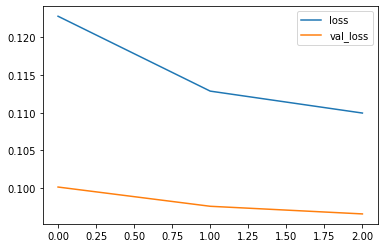

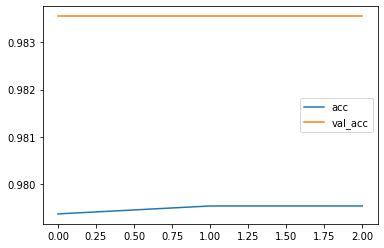

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [ ]:
p = model.predict(x_training)
aucs = []
for j in range(6):
    auc = roc_auc_score(y_training[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.8612828382619467


In [ ]:
# scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (e[1]*100))

Accuracy: 98.78%


In [ ]:
model.save('/content/gdrive/My Drive/GEC_7C.h5')